### Detailed Explanation of the House Price Prediction Project

This project aims to predict house prices using a sophisticated machine learning pipeline, leveraging feature engineering, robust preprocessing, and an advanced stacking ensemble model. The goal is to achieve high accuracy and provide insightful visualizations for model evaluation.

#### 1. Library Imports
The initial block imports all necessary libraries for data manipulation (`pandas`, `numpy`), visualization (`matplotlib.pyplot`, `seaborn`), machine learning utilities (`sklearn.datasets`, `sklearn.model_selection`, `sklearn.preprocessing`, `sklearn.impute`, `sklearn.compose`, `sklearn.pipeline`, `sklearn.metrics`), and specific models (`sklearn.ensemble.StackingRegressor`, `sklearn.ensemble.RandomForestRegressor`, `sklearn.linear_model.LassoCV`, `sklearn.linear_model.RidgeCV`, `xgboost.XGBRegressor`, `lightgbm.LGBMRegressor`). This comprehensive set of imports allows for building a powerful and flexible model.

#### 2. Load Dataset (Ames Housing)
- The `fetch_openml` function is used to download the 'house_prices' (Ames Housing) dataset directly. This dataset is a standard benchmark for regression tasks in real estate.
- `as_frame=True` ensures the data is loaded into a pandas DataFrame.
- The target variable, `SalePrice`, is log-transformed using `np.log1p(df['SalePrice'])`. This is crucial because house prices often have a skewed distribution (a few very expensive homes can heavily influence the model). Log transformation normalizes this distribution, making it easier for models to learn patterns and reducing the impact of outliers. `Id` column is dropped as it's just an identifier and not a feature.

#### 3. Enhanced Feature Engineering
This section creates new, more informative features from the raw data, helping the model better understand the underlying patterns:
- `HouseAge`: Calculated as `YrSold - YearBuilt`. This directly captures the age of the house, which is a significant factor in property value.
- `TotalSF`: Sum of `TotalBsmtSF`, `1stFlrSF`, and `2ndFlrSF`. This provides a comprehensive measure of the total living area, a primary driver of house price.
- Binary Indicators (`HasPool`, `HasGarage`, `HasBsmt`, `HasFireplace`): These features convert categorical presence/absence information (e.g., `PoolQC` having a value or being NaN) into simple binary (0 or 1) indicators. This simplifies the input for the model and highlights the presence of key amenities.
- `RemodelAge`: `YrSold - YearRemodAdd`. Captures the time since the last remodel, indicating the modernity of the house.
- `TotalSF_OverallQual`: An interaction feature, `TotalSF * OverallQual`. This signifies that the impact of square footage on price is amplified by the overall quality of the house. A larger, high-quality house is valued disproportionately higher than a larger, low-quality house.
- `OverallQual_sq`: `OverallQual**2`. Squaring the `OverallQual` feature can capture non-linear relationships, suggesting that higher quality levels might have an exponentially greater impact on price.
- `X` and `y` are defined: `X` contains all features except `SalePrice` and `Id`, and `y` is the log-transformed `SalePrice`.

#### 4. Preprocessing Pipeline
This section sets up a robust and automated way to clean and transform the data before it's fed into the models, preventing data leakage and ensuring consistency.
- `num_cols` and `cat_cols`: Columns are separated into numerical and categorical types.
- `num_transformer`: A `Pipeline` for numerical features:
    - `SimpleImputer(strategy='median')`: Fills missing numerical values with the median of their respective columns, which is robust to outliers.
    - `StandardScaler()`: Scales numerical features to have zero mean and unit variance. This is important for many models (especially linear models and distance-based algorithms) to prevent features with larger scales from dominating the learning process.
- `cat_transformer`: A `Pipeline` for categorical features:
    - `SimpleImputer(strategy='most_frequent')`: Fills missing categorical values with the most frequent category.
    - `OneHotEncoder(handle_unknown='ignore', sparse_output=False)`: Converts categorical features into a one-hot encoded format (binary columns for each category). `handle_unknown='ignore'` prevents errors during prediction if a new, unseen category appears.
- `preprocessor`: A `ColumnTransformer` that applies the `num_transformer` to `num_cols` and `cat_transformer` to `cat_cols`.
- `preprocessor.set_output(transform="pandas")`: Ensures that the output of the preprocessor is a pandas DataFrame with feature names, which can be useful for downstream models or inspection.

#### 5. Define Ensemble (Stacking with Diversity)
This is the core of the model, using a stacking ensemble approach to combine the strengths of multiple diverse models.
- **Base Learners (Level 0)**: A list of diverse models that learn from the original (preprocessed) features:
    - `RidgeCV` and `LassoCV`: Regularized linear models that are good at capturing linear relationships and performing feature selection. `cv=5` indicates 5-fold cross-validation for hyperparameter tuning.
    - `RandomForestRegressor`: An ensemble tree-based model known for its robustness and ability to capture non-linear relationships.
    - `XGBRegressor` and `LGBMRegressor`: Gradient boosting models, highly powerful and often top performers in tabular data tasks, known for their ability to model complex interactions.
- **Meta-Model (Level 1)**: `StackingRegressor` takes the predictions of the base learners as new features and trains a `final_estimator` (another `LassoCV` in this case) on these predictions. This allows the meta-model to learn how to best combine the insights from the base models, effectively weighting their contributions. `cv=5` is used for training the meta-model.

#### 6. Execution Pipeline
- `model_pipeline`: Combines the `preprocessor` and the `ensemble` model into a single `Pipeline`. This ensures that all preprocessing steps are applied consistently before the model is trained or makes predictions.
- `train_test_split`: The data is split into training (80%) and testing (20%) sets. The test set is held out and used only for final evaluation to simulate unseen data performance.
- `model_pipeline.fit(X_train, y_train)`: The entire pipeline (preprocessing + stacking ensemble) is trained on the training data. This step can be computationally intensive due to the complexity of the stacking model.

#### 7. K-Fold Cross-Validation (Robust Evaluation)
To get a more reliable estimate of the model's performance and stability, K-Fold Cross-Validation is performed.
- `KFold(n_splits=5, shuffle=True, random_state=42)`: Defines a 5-fold cross-validation strategy, shuffling the data to ensure each fold is representative.
- `cross_validate`: Evaluates the `model_pipeline` across the 5 folds. It calculates specified scoring metrics (`neg_mean_squared_error`, `r2`) for both training and testing sets.
- The average RMSE and R2 scores are calculated and displayed. `rmse_scores.std()` indicates the variability of the model's performance across different folds, giving an idea of its stability.
- Comparing `Average CV R2` with `Average Train R2` helps in checking for overfitting. A large gap typically indicates overfitting.

#### 8. Visualization and Error Analysis
This section uses plots to visually assess the model's performance and identify areas for improvement.
- `y_pred = model_pipeline.predict(X_test)`: Predictions are made on the unseen `X_test` data.
- `residuals = y_test - y_pred`: The difference between actual and predicted values is calculated.
- **Actual vs. Predicted Plot**: `sns.regplot` plots `y_test` against `y_pred`. Ideally, points should cluster tightly around the red regression line (y=x), indicating accurate predictions. Deviations show where the model might be struggling.
- **Residual Plot**: `sns.scatterplot` plots `y_pred` against `residuals`. For a good model, residuals should be randomly scattered around zero with no discernible pattern. Patterns (like a cone shape, a curve, or clusters) suggest that the model has systematic errors or heteroscedasticity, meaning it performs better or worse for certain ranges of predicted values. This helps diagnose model weaknesses.

In summary, this project implements a powerful and well-validated machine learning solution for house price prediction, focusing on data preparation, ensemble modeling, and thorough evaluation.

Loading Ames Housing Dataset...
Training Advanced Stacking Ensemble... (This may take a minute)

Performing 5-Fold Cross-Validation...
Average CV RMSE: 0.1317 (+/- 0.0337)
Average CV R2: 0.8798
Average Train R2: 0.9883 (Checking for Overfit)


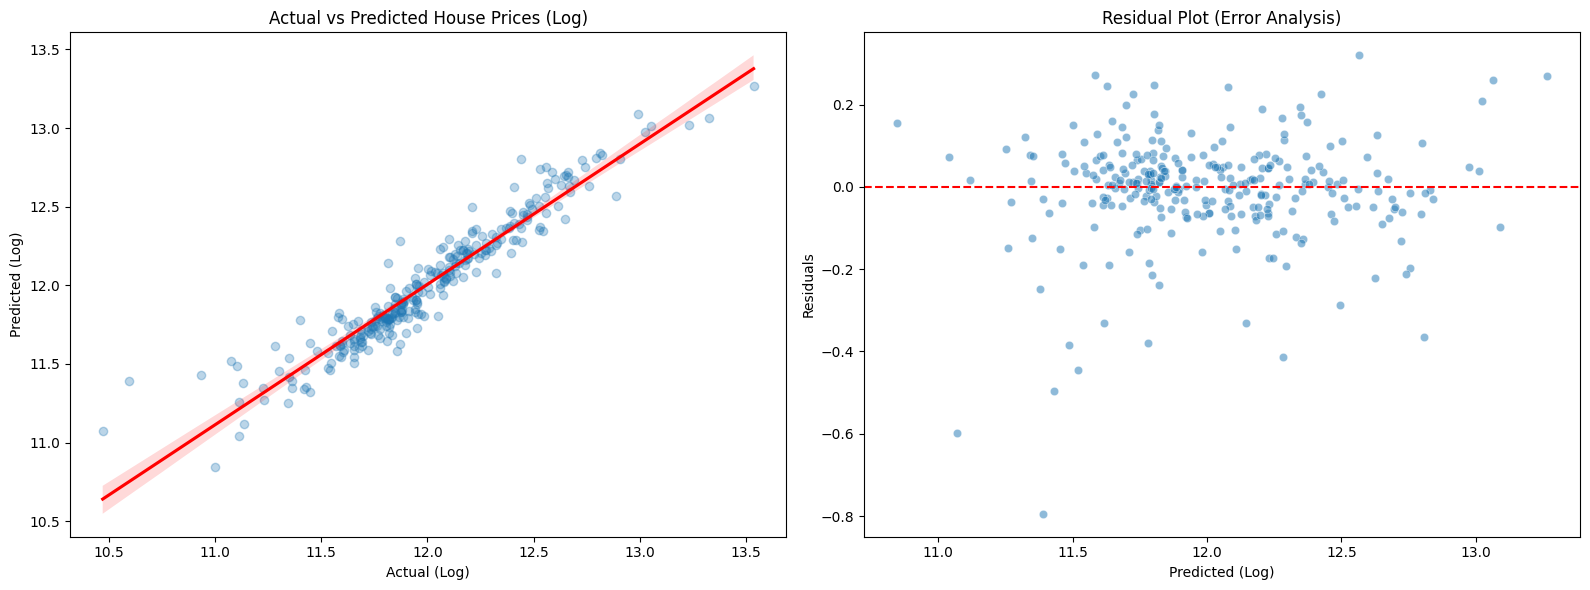

Project processing complete.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. LOAD DATASET (Ames Housing)
print("Loading Ames Housing Dataset...")
housing = fetch_openml(name="house_prices", as_frame=True, parser='auto')
df = housing.frame

# 2. ENHANCED FEATURE ENGINEERING
# Capturing temporal decay and property size
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# Binary indicators for key amenities
df['HasPool'] = df['PoolQC'].notna().astype(int)
df['HasGarage'] = df['GarageType'].notna().astype(int)
df['HasBsmt'] = df['BsmtQual'].notna().astype(int)
df['HasFireplace'] = df['FireplaceQu'].notna().astype(int)

# Domain-specific temporal and interaction features
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
df['TotalSF_OverallQual'] = df['TotalSF'] * df['OverallQual']
df['OverallQual_sq'] = df['OverallQual']**2

# Define Target and Features
X = df.drop(['SalePrice', 'Id'], axis=1)
y = np.log1p(df['SalePrice']) # Log transform to handle skewness

# 3. PREPROCESSING PIPELINE
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])
# Ensure feature names are retained for models like LightGBM
preprocessor.set_output(transform="pandas")

# 4. DEFINE ENSEMBLE (Stacking with Diversity)
# Level 0: Diverse Base Learners
base_learners = [
    ('ridge', RidgeCV(cv=5)),
    ('lasso', LassoCV(cv=5, max_iter=10000)), # Increased iterations for convergence
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=1000, learning_rate=0.05, verbose=-1, random_state=42))
]

# Level 1: Meta-Model (Lasso handles feature selection from base predictions)
stack_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=LassoCV(cv=5, max_iter=10000),
    cv=5
)

# 5. EXECUTION PIPELINE
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', stack_model)
])

# Split Data for Initial Hold-out Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
print("Training Advanced Stacking Ensemble... (This may take a minute)")
model_pipeline.fit(X_train, y_train)

# 6. K-FOLD CROSS-VALIDATION (Robust Evaluation)
print("\nPerforming 5-Fold Cross-Validation...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(model_pipeline, X, y, cv=kf,
                            scoring=('neg_mean_squared_error', 'r2'),
                            return_train_score=True)

# Display CV Results
rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
print(f"Average CV RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std():.4f})")
print(f"Average CV R2: {cv_results['test_r2'].mean():.4f}")
print(f"Average Train R2: {cv_results['train_r2'].mean():.4f} (Checking for Overfit)")

# 7. VISUALIZATION AND ERROR ANALYSIS
y_pred = model_pipeline.predict(X_test)
residuals = y_test - y_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, ax=ax1)
ax1.set_title("Actual vs Predicted House Prices (Log)")
ax1.set_xlabel("Actual (Log)")
ax1.set_ylabel("Predicted (Log)")

# Residual Plot
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=ax2)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_title("Residual Plot (Error Analysis)")
ax2.set_xlabel("Predicted (Log)")
ax2.set_ylabel("Residuals")

plt.tight_layout()
plt.show()

print("Project processing complete.")